## Bank Marketing dataset

### 1. Dataset preparation

In [424]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [425]:
df = pd.read_csv('bank-full.csv', sep=';')

In [426]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [427]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [428]:
df.y = (df.y == 'yes').astype(int)

### 2. Perform the train/validation/test split with Scikit-Learn

In [429]:
from sklearn.model_selection import train_test_split

In [430]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [431]:
len(df_full_train), len(df_test)

(36168, 9043)

In [432]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [433]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [434]:
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,blue-collar,married,primary,no,2519,yes,no,unknown,15,may,262,4,-1,0,unknown,0
1,37,technician,married,secondary,no,2209,no,no,unknown,20,jun,167,2,-1,0,unknown,0
2,32,admin.,married,secondary,no,923,yes,no,cellular,17,apr,819,4,-1,0,unknown,0
3,53,blue-collar,married,primary,no,306,no,no,cellular,28,jul,388,3,181,1,success,1
4,32,technician,single,tertiary,no,257,yes,no,unknown,2,jun,183,5,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9038,56,housemaid,married,primary,no,0,no,no,cellular,26,aug,102,2,-1,0,unknown,0
9039,33,services,single,secondary,no,3910,yes,no,cellular,19,nov,676,2,-1,0,unknown,0
9040,44,unknown,married,unknown,no,1317,no,no,telephone,31,jul,444,6,-1,0,unknown,0
9041,31,management,single,tertiary,no,305,yes,no,unknown,28,may,297,14,-1,0,unknown,0


In [435]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [436]:
del df_train['y']
del df_val['y']
del df_test['y']

### 3. Exploratory data analysis
- looking at the y variable
- separating the numerical and categorical variables

In [437]:
df_full_train.y.value_counts(normalize=True)

y
0    0.882797
1    0.117203
Name: proportion, dtype: float64

In [438]:
df_full_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [439]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [440]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [441]:
df_full_train[categorical]

,job,marital,education,housing,contact,month,poutcome
22468,management,married,tertiary,no,cellular,aug,unknown
6896,admin.,single,secondary,yes,unknown,may,unknown
28408,blue-collar,married,primary,yes,cellular,jan,failure
8481,technician,married,secondary,yes,unknown,jun,unknown
28753,services,single,secondary,no,cellular,jan,unknown
...,...,...,...,...,...,...,...
43723,technician,married,tertiary,no,cellular,may,unknown
32511,management,divorced,tertiary,yes,cellular,apr,unknown
5192,management,married,tertiary,no,unknown,may,unknown
12172,admin.,married,unknown,no,unknown,jun,unknown


In [442]:
df_full_train[numerical]

,age,balance,day,duration,campaign,pdays,previous
22468,52,0,22,232,2,-1,0
6896,50,330,28,24,1,-1,0
28408,45,300,29,203,1,261,3
8481,38,27,3,404,4,-1,0
28753,31,887,30,427,1,-1,0
...,...,...,...,...,...,...,...
43723,50,1830,14,318,3,-1,0
32511,34,528,17,233,2,-1,0
5192,48,4191,21,363,6,-1,0
12172,45,1783,20,11,11,-1,0


### 4. Evaluating the feature importance of the numerical variables using ROC AUC

In [443]:
from sklearn.metrics import roc_auc_score

In [444]:
numerical_vars = ['balance', 'day', 'duration', 'previous']

# Initialize a dictionary to store AUC scores
feature_auc = {}

# Calculate AUC for each specified numerical feature
for column in numerical_vars:
    # Calculate AUC score
    auc_score = roc_auc_score(y_train, df_train[column])
    feature_auc[column] = auc_score

    # Check AUC score and invert if less than 0.5
    if auc_score < 0.5:
        df_train[column] = -df_train[column]  # Invert the variable

# Convert the AUC scores to a DataFrame for easier viewing
auc_df = pd.DataFrame(feature_auc.items(), columns=['Feature', 'AUC'])

# Display the AUC scores
print(auc_df)

    Feature       AUC
0   balance  0.588831
1       day  0.474042
2  duration  0.814700
3  previous  0.598565


#### `Duration` has the highest AUC of 0.81, implying a strong positive correlation with the target.

Since the AUC of `day` is less than 0.5 even after inversion, it shows that the day variable may inherently have a weak or no correlation with the target, regardless of whether it's inverted.

### 5. Training the model
- Applying one-hot-encoding using `DictVectorizer`.

In [445]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [446]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [447]:
model.intercept_[0]

np.float64(-0.9699802709169372)

In [448]:
model.coef_[0].round(3)

array([-0.003,  0.   , -0.088,  0.218,  0.132, -1.321, -0.008,  0.004,
       -0.42 , -0.244, -0.089, -0.218, -0.165, -0.804,  0.007, -0.299,
       -0.267, -0.361, -0.101,  0.376, -0.165, -0.166,  0.527, -0.232,
       -0.152, -0.136, -0.345, -0.44 , -0.185, -0.122, -0.703,  0.274,
       -0.388, -1.271, -0.939,  0.423,  1.589, -0.525, -1.005,  0.982,
        0.716, -0.   , -0.78 , -0.739,  1.467, -0.918,  0.014])

In [449]:
model.predict(X_train)  #Hard predictions of subscription_to_term_deposit values

array([0, 0, 0, ..., 0, 0, 0])

In [450]:
y_scores = model.predict_proba(X_train) #Soft predictions, two dimensional matrix...the right column is the probability of subscribing to term deposit.
y_scores

array([[0.96478563, 0.03521437],
       [0.93921077, 0.06078923],
       [0.96935648, 0.03064352],
       ...,
       [0.99845007, 0.00154993],
       [0.96240967, 0.03759033],
       [0.97449961, 0.02550039]])

### 6. Applying the model to the validation dataset

In [451]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [452]:
X_val = dv.transform(val_dicts)

In [453]:
y_pred = model.predict_proba(X_val)[:, 1]

In [454]:
roc_auc_score(y_val, y_pred)  #finding the AUC of the model on the validation dataset

np.float64(0.8994227809603472)

### 7. Precision and Recall
- Evaluating the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, computing precision and recall
- Plotting them

In [455]:
from sklearn.metrics import accuracy_score

In [456]:
accuracy_score(y_val, y_pred >= 0.5)

0.8974784339747843

##### An accuracy score of ~ 0.90 that approximately 89.75% of the predictions made by the model were correct.

In other words, when the model's predicted probabilities were thresholded at 0.5, about 89.75% of the resulting classifications matched the actual labels in y_val. The model accurately classified close to 90% of the examples in the validation set (y_val).

In [457]:
from sklearn.metrics import precision_score, recall_score

The first point of intersection between precision and recall curves is at threshold: 0.29


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


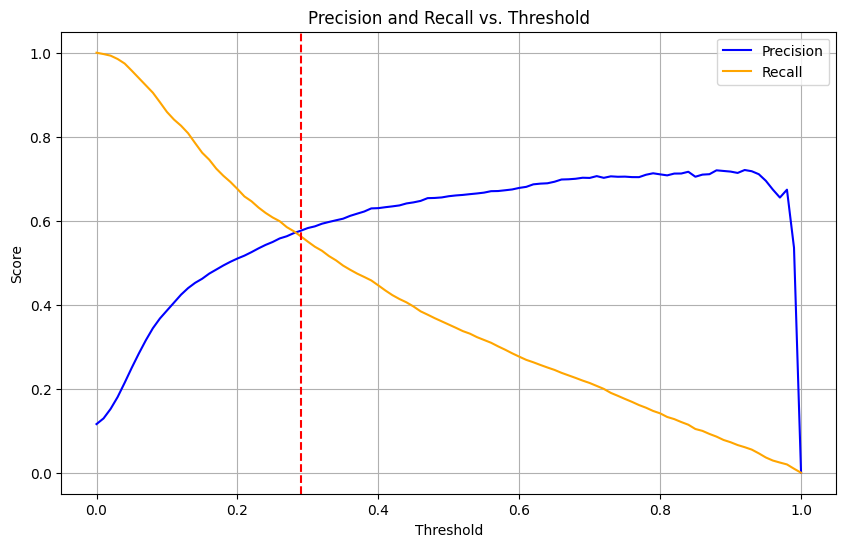

In [458]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

# Assuming df_train is your training DataFrame and y_train is your target variable
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Fit the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_scores = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

# Initialize lists to hold precision and recall values
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds from 0.0 to 1.0

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions
    y_pred = (y_scores >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Find the first threshold where precision and recall intersect
first_intersection_threshold = None
for i in range(1, len(thresholds)):
    # Check for the first point where precision and recall are approximately equal
    if (precisions[i-1] < recalls[i-1] and precisions[i] >= recalls[i]) or (precisions[i-1] > recalls[i-1] and precisions[i] <= recalls[i]):
        first_intersection_threshold = thresholds[i]
        break  # Stop after finding the first intersection

# Print the first intersection threshold
if first_intersection_threshold is not None:
    print(f"The first point of intersection between precision and recall curves is at threshold: {first_intersection_threshold}")
else:
    print("No intersection point found within the defined thresholds.")

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')

# Highlight the first intersection threshold on the plot, if it exists
if first_intersection_threshold is not None:
    plt.axvline(x=first_intersection_threshold, color='red', linestyle='--')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

### 8. F1 score


Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [459]:
from sklearn.metrics import precision_recall_curve, f1_score

In [460]:
# Get predicted probabilities for the positive class
y_scores = model.predict_proba(X_train)[:, 1]

# Initialize lists to hold thresholds and F1 scores
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

# Compute F1 score for each threshold
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
    f1 = f1_score(y_train, y_pred)  # Calculate F1 score
    f1_scores.append(f1)

# Find the threshold where F1 is maximal
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_scores[max_f1_index]

print(f'Maximum F1 score is {max_f1_value} at threshold: {max_f1_threshold}')

Maximum F1 score is 0.5821734475374732 at threshold: 0.19


### 9. 5-Fold CV

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

In [461]:
from sklearn.model_selection import KFold

In [466]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

# Prepare your data
X = df_full_train[categorical + numerical]
y = df_full_train['y']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores = []

# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split the data into train and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Convert training and validation data into dictionaries for DictVectorizer
    train_dicts = X_train.to_dict(orient='records')
    val_dicts = X_val.to_dict(orient='records')

    # Fit DictVectorizer on the training data and transform both train and val data
    X_train_transformed = dv.fit_transform(train_dicts)
    X_val_transformed = dv.transform(val_dicts)

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_transformed, y_train)

    # Make predictions
    y_scores = model.predict_proba(X_val_transformed)[:, 1]

    # Compute AUC score
    auc = roc_auc_score(y_val, y_scores)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores
std_dev_auc = np.std(auc_scores)

print(f"AUC scores for each fold: {auc_scores}")
print(f"The Standard deviation of AUC scores across different folds: {std_dev_auc}")


AUC scores for each fold: [np.float64(0.8992842405563055), np.float64(0.8990110164487815), np.float64(0.9111641244449282), np.float64(0.9078905031338849), np.float64(0.9119728949040351)]
The Standard deviation of AUC scores across different folds: 0.005652844370349586


##### Transformed the training and validation data using DictVectorizer in each fold of the K-Fold cross-validation. This ensures that all categorical variables are correctly one-hot encoded.

Used to_dict(orient='records') to convert DataFrame rows into dictionaries for transformation by DictVectorizer.

### 10. Hyperparameter Tuning
Using 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [467]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# C values to evaluate
C_values = [0.000001, 0.001, 1]

# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Store results for each C value
results = {}

# Iterate over each C value
for C in C_values:
    auc_scores = []
    
    # Iterate over each fold
    for train_index, val_index in kf.split(X):
        # Split the data into train and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Convert training and validation data into dictionaries for DictVectorizer
        train_dicts = X_train.to_dict(orient='records')
        val_dicts = X_val.to_dict(orient='records')

        # Fit DictVectorizer on the training data and transform both train and val data
        X_train_transformed = dv.fit_transform(train_dicts)
        X_val_transformed = dv.transform(val_dicts)

        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_transformed, y_train)

        # Make predictions
        y_scores = model.predict_proba(X_val_transformed)[:, 1]

        # Compute AUC score
        auc = roc_auc_score(y_val, y_scores)
        auc_scores.append(auc)

    # Calculate mean and standard deviation of AUC scores
    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)

    # Store results
    results[C] = {'mean_auc': mean_auc, 'std_auc': std_auc}

# Print the results
for C, scores in results.items():
    print(f"C: {C}, Mean AUC: {scores['mean_auc']}, Std AUC: {scores['std_auc']}")


C: 1e-06, Mean AUC: 0.701, Std AUC: 0.009
C: 0.001, Mean AUC: 0.861, Std AUC: 0.007
C: 1, Mean AUC: 0.906, Std AUC: 0.006


##### Explanation of the Code:
1. Data Preparation: The features X and the target y are defined from your DataFrame.
2. KFold Initialization: The K-Fold cross-validator is set up with 5 splits.
3. Iterating Over C Values: For each `𝐶` value:
- An empty list for storing AUC scores is initialized.
- Each fold of the K-Fold is iterated to split the data into training and validation sets.
- The `DictVectorizer` is used to transform the categorical and numerical features.
- The logistic regression model is trained using the current `𝐶` value.
- AUC scores are calculated and stored for each fold.
4. Mean and Standard Deviation Calculation: After completing all folds for a specific `𝐶`, the mean and standard deviation of the AUC scores are computed and rounded to three decimal places.
5. Results Output: Finally, the mean and standard deviation of AUC scores for each `𝐶` are printed.

  The code below helps identify which `C` value yields the best performance based on the mean AUC score across the folds.